**Table of contents**<a id='toc0_'></a>    
- [Setup](#toc1_)    
- [Test questions](#toc2_)    
- [Implementation](#toc3_)    
  - [Preprocessing BUV q&a file](#toc3_1_)    
    - [Text loader](#toc3_1_1_)    
    - [Splitter](#toc3_1_2_)    
  - [Preprocessing student handbook file](#toc3_2_)    
  - [Combine two docs](#toc3_3_)    
  - [Count token](#toc3_4_)    
  - [Retrievers](#toc3_5_)    
    - [Parent document retrievers](#toc3_5_1_)    
    - [Test chunk size](#toc3_5_2_)    
      - [Reload parent document retriever](#toc3_5_2_1_)    
    - [Rephrase retriever](#toc3_5_3_)    
  - [Create chain](#toc3_6_)    
  - [Add sources](#toc3_7_)    
- [Testing](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
import os
import pandas as pd
pd.set_option("display.max_colwidth", None)

os.environ["AZURE_OPENAI_ENDPOINT"] = "https://dalle3-swo.openai.azure.com/"
os.environ["AZURE_OPENAI_API_KEY"] = "e51119f8d8774069a6594d92ccf7a70d"

In [3]:
from langchain_community.utilities import GoogleSearchAPIWrapper
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings, OpenAIEmbeddings
from langchain_core.output_parsers import BaseOutputParser
from typing import List, Optional
import re
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import chain
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo",
    temperature=0
) 

gpt_35_turbo_16k = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo-16k",
    temperature=0
) 

smart_llm = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-4",
    temperature=0
) 
gpt_35_turbo_instruct = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo-instruct",
    temperature=0
) 
# Embedding

embeddings_3_large = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-large",
    openai_api_version="2024-02-15-preview",
    max_retries=5,
    retry_min_seconds=30,
    retry_max_seconds=120,
    show_progress_bar=True
)

# <a id='toc2_'></a>[Test questions](#toc0_)

In [4]:
question_lists = [
    "Who should I contact if I want to ask for my timetable",
    "Which department should I contact if I want to ask about my timetable?",
    "Who should I contact if I want to ask about my attendance",    
    "Which department should I contact if I want to ask about my attendance?",
    "How can I contact Mr. Frazer?",
    "May I ask for Mr. Frazer phone number?",
    "I got a question regarding my exam schedule, who should I contact?",
    "I got a question regarding my exam schedule, what department should I contact?",
    "I want to ask for academic support",
    "I need more information about the Student Tutor programme",
    "I want to know about the Faculty Learning Support programme"
]

# <a id='toc3_'></a>[Implementation](#toc0_)

## <a id='toc3_1_'></a>[Preprocessing BUV q&a file](#toc0_)

In [5]:
buv_qna = pd.read_excel('../../data/qna_update_data/process_data/buv_jul24_qna.xlsx')

In [6]:
buv_qna.columns

Index(['page_content', 'file_name', 'page'], dtype='object')

In [7]:
from langchain.docstore.document import Document

buv_qna_docs = []
for row in buv_qna.itertuples(index=True, name='Pandas'):
    document = Document(page_content=row.page_content, 
                        metadata = {"file_name": row.file_name, 
                                    "page": row.page})
    buv_qna_docs.append(document)

In [8]:
len(buv_qna_docs)

75

In [9]:
print(buv_qna_docs[3].page_content)

If the academic results of students are not good enough and students/parents are worried, what can BUV support to improve their performance? / Sinh viên/phụ huynh lo rằng kết quả học tập của sinh viên không đủ tốt, liệu nhà trường có kế hoạch gì trong việc giúp đỡ sinh viên cải thiện kết quả học tập không?

Answer / Câu trả lời:

To improve students’ performance in specific modules, the best way is to stay engaged & reach out to the Modules Leaders for their support. This semester, module teams will be posting their “Office Hours” on the front page of their Canvas site near where you find their email address. To make use of Office Hours, the students can email their preferred module team members and request a meeting within those hours. In the case that the students are unable to attend the posted Office Hours, the module teams may be able to meet the students at other times depending on their availability.

Moreover, at BUV, we are dedicated to providing comprehensive academic support

In [10]:
print(buv_qna_docs[0].metadata)

{'file_name': 'BUV-JUL24-FAQ.pdf', 'page': 10}


## <a id='toc3_2_'></a>[Preprocessing student handbook file](#toc0_)

In [11]:
student_handbook_df = pd.read_excel('../../data/qna_update_data/process_data/student_handbook_23_24.xlsx')

In [12]:
from langchain.docstore.document import Document

student_handbook_docs = []
for row in student_handbook_df.itertuples(index=True, name='Pandas'):
    document = Document(page_content=row.page_content, 
                        metadata = {"file_name": row.file_name, 
                                    "page": row.page})
    student_handbook_docs.append(document)

In [13]:
len(student_handbook_docs)

62

In [14]:
print(student_handbook_docs[3].page_content)

## University Contact Points  
The official communication channels in every course are Student emails and Canvas LMS. Students are expected to use Student emails to contact and communicate with the Academic Team throughout the course.  
For any module related matters, it is recommended that all communications should be done via Canvas LMS. For any other supports related to Academic Administration, your first point of contact should always be the Student Information Office located at the Student Information Counter on level 2, BUV Campus.  
| Admission Office Provides support and guidance for inquires relate to all Admissions procedure including pre-arrival inquiries. | admissions@buv.edu.vn |
| - | - |
| Course Office Provides support and guidance for inquires relate to Timetable, Class Arrangement, Status changes, Course Operations, Programme and Module Administration. | courseoffice@buv.edu.vn |
| Student Information Office Provides support and guidance for inquiries relate to Attend

In [15]:
print(student_handbook_docs[0].metadata['file_name'])

Student Handbook 2023-2024.pdf


## Process psg file

In [16]:
psg_handbook_df = pd.read_excel('../../data/qna_update_data/process_data/psg_programme_handbook_23_24.xlsx')

In [17]:
from langchain.docstore.document import Document

psg_handbook_docs = []
for row in psg_handbook_df.itertuples(index=True, name='Pandas'):
    document = Document(page_content=row.page_content, 
                        metadata = {"file_name": row.file_name, 
                                    "page": row.page})
    psg_handbook_docs.append(document)

In [18]:
len(psg_handbook_docs)

31

In [19]:
print(psg_handbook_docs[0].metadata)

{'file_name': 'PSG Programme Handbook.pdf', 'page': 3}


In [20]:
print(psg_handbook_docs[28].page_content)

### If I am not a student-led project leader, how can I earn points in the University and Community Engagement quadrant?  
Keep in mind that student-led projects do not need to be fancy, complicated or too far-reaching. Simply initiating an idea or attempting to run a campaign to raise awareness on social issues, e.g., cyber-bullying or recycling, can already be a meaningful project for the students. BUV fully supports students to try new things and experience growth in the most active way possible.  
Members’ contributions will be recognised by the Core Organising Team (Project Leader, or Heads of Functions) during an evaluation process after each project and event. This evaluation process ensures that the members/coordinators/officers contribute and learn efficiently during the event/project. After the evaluation, members/coordinators/officers can receive from 20 to 80 points depending on the level of contribution assessed by their leaders.


## <a id='toc3_3_'></a>[Combine three docs](#toc0_)

In [21]:
final_docs =  buv_qna_docs + student_handbook_docs + psg_handbook_docs

In [22]:
len(final_docs)

168

## <a id='toc3_4_'></a>[Count token](#toc0_)
Per parent document

In [40]:
list_page_content = [doc.page_content for doc in final_docs]

In [41]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


num_tokens = list(map(num_tokens_from_string, list_page_content))

<Axes: ylabel='Frequency'>

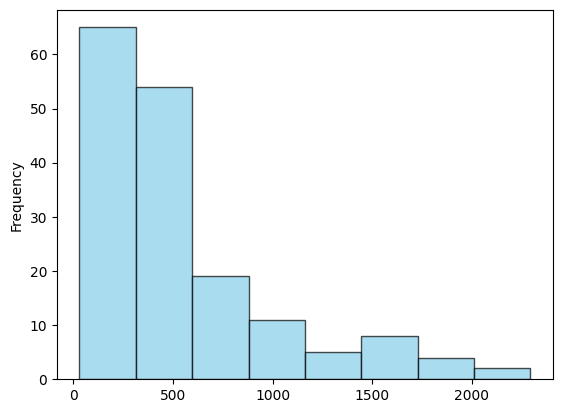

In [42]:
import pandas as pd
# Create a DataFrame from the list
df = pd.DataFrame(num_tokens, columns=['Value'])

# Plot the distribution
df['Value'].plot(kind='hist', bins=8, color='skyblue', edgecolor='black', alpha=0.7)
# df['Value'].plot(kind='kde', color='red')


In [43]:
df.describe()

,Value
count,168.000000
mean,547.434524
std,479.820958
min,31.000000
25%,217.750000
50%,387.000000
75%,668.250000
max,2294.000000


## <a id='toc3_5_'></a>[Retrievers](#toc0_)

### <a id='toc3_5_1_'></a>[Parent document retrievers](#toc0_)

In [23]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore, LocalFileStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage._lc_store import create_kv_docstore


# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400, chunk_overlap=100, add_start_index=True
)
# The vectorstore to use to index the child chunks
vectorstore_chunk_zie_400 = Chroma(
    persist_directory="./chroma_db/buv_embedding_400_large_with_source", embedding_function=embeddings_3_large
)
# The storage layer for the parent documents
# store = InMemoryStore()
fs = LocalFileStore("./parent_document_store/buv_embedding_large_with_source")
store = create_kv_docstore(fs)
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore_chunk_zie_400,
    docstore=store,
    child_splitter=child_splitter,
    search_kwargs={"k": 2},
)

In [24]:
parent_document_retriever.add_documents(final_docs, ids=None)
# parent_document_retriever.add_documents(final_docs[:84], ids=None)
# parent_document_retriever.add_documents(final_docs[84:], ids=None)

/Users/macos/Documents/SWO/buvBot/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [01:25<00:00, 85.61s/it]


In [25]:
len(list(store.yield_keys()))

168

### <a id='toc3_5_2_'></a>[Test chunk size](#toc0_)

In [15]:
# chunk_size 300
# text_splitter_300 = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=100)
# docs_300 = text_splitter_300.split_documents(final_docs)
# db_chunk_size_300 = Chroma.from_documents(docs_300, embeddings_3_large,
#                                           persist_directory="buv_and_student_handbook_300_embedding_large")

db_chunk_size_300 = Chroma(persist_directory="buv_and_student_handbook_300_embedding_large",
                           embeddings=embeddings_3_large)


In [16]:
# # chunk_size 300
# text_splitter_350 = RecursiveCharacterTextSplitter(chunk_size=350, chunk_overlap=100)
# docs_350 = text_splitter_350.split_documents(final_docs)
# db_chunk_size_350 = Chroma.from_documents(docs_350, embeddings_3_large, 
#                                           persist_directory="buv_and_student_handbook_350_embedding_large")
db_chunk_size_350 = Chroma(persist_directory="buv_and_student_handbook_350_embedding_large",
                           embeddings=embeddings_3_large)

In [32]:
question_lists

['Who should I contact if I want to ask for my timetable',
 'Which department should I contact if I want to ask about my timetable?',
 'Who should I contact if I want to ask about my attendance',
 'Which department should I contact if I want to ask about my attendance?',
 'How can I contact Mr. Frazer?',
 'May I ask for Mr. Frazer phone number?',
 'I got a question regarding my exam schedule, who should I contact?',
 'I got a question regarding my exam schedule, what department should I contact?',
 'I want to ask for academic support',
 'I need more information about the Student Tutor programme',
 'I want to know about the Faculty Learning Support programme']

In [55]:
a = db_chunk_size_300.similarity_search("May I ask for Mr. Frazer phone number?")

In [58]:
print(a[2].page_content)

If you or your friend are in a medical emergency case and cannot come to Medical Suite, please reach out to our emergency hotline 090 215 7558 for prompt assistance.  
Hours of operation:  
From Monday to Friday, 08:30 - 17:30  
Weekend operations are dependent on events/activities and classes.


In [59]:
a = db_chunk_size_350.similarity_search("May I ask for Mr. Frazer phone number?")

In [60]:
print(a[0].page_content)

and up to 4 minutes 59 seconds after the timetabled end of the session. Students should also immediately inform the Student Information Office on the 2nd floor in person about any FRS issue.


In [61]:
print(a[1].page_content)

If you or your friend are in a medical emergency case and cannot come to Medical Suite, please reach out to our emergency hotline 090 215 7558 for prompt assistance.  
Hours of operation:  
From Monday to Friday, 08:30 - 17:30  
Weekend operations are dependent on events/activities and classes.


In [12]:
a = vectorstore_chunk_zie_400.similarity_search("Which department and how should I contact if I want to ask about my timetable?")

In [15]:
print(a[2].page_content)

| Admission Office Provides support and guidance for inquires relate to all Admissions procedure including pre-arrival inquiries. | admissions@buv.edu.vn |
| - | - |
| Course Office Provides support and guidance for inquires relate to Timetable, Class Arrangement, Status changes, Course Operations, Programme and Module Administration. | courseoffice@buv.edu.vn |


In [1]:
b = parent_document_retriever.invoke("I got a question regarding my exam schedule, who should I contact?")

NameError: name 'parent_document_retriever' is not defined

In [78]:
print(b[0].page_content)

## Academic Misconduct Regulation  
Academic Conduct and Misconduct for IFP/UOL students, please refer to UOL General Regulations and Programme Regulations which can be found here:  
https://www.london.ac.uk/current-students/programme-documents/regulations#undergraduate-29612  
General Regulations AY 2022/23 (for both UOL&IFP) https://www.london.ac.uk/sites/default/files/regulations/generalregs-2022-23-v2.pdf  
UOL Programme Regulations AY 2022/2023  
https://www.london.ac.uk/sites/default/files/progregs-emfss-online-taught-2022-2023-19-07-23.pdf  
IFP Programme Regulations AY 2022/2023  
https://www.london.ac.uk/sites/default/files/regulations/progregs-ifp-2022-2023.pdf  
Academic Misconduct is any action which could give you, or someone else, an unfair advantage in an assessment, including examinations. It is also any actions which could undermine the fairness of assessment and research at the University.  
There are different types of academic misconduct. You can find a list at: htt

#### <a id='toc3_5_2_1_'></a>[Reload parent document retriever](#toc0_)

In fact, the ParentDocumentRetriever could be replaced by a MultiVectorRetriever instance since the difference between the two is the add_documents method that the ParentDocumentRetriever has.

Refer to here: https://github.com/langchain-ai/langchain/issues/9345

In [5]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore, LocalFileStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage._lc_store import create_kv_docstore
from langchain.retrievers import MultiVectorRetriever


# The vectorstore to use to index the child chunks
vectorstore_chunk_zie_400 = Chroma(
    persist_directory="./chroma_db/buv_and_student_handbook_400", embedding_function=embeddings
)
# The storage layer for the parent documents
# store = InMemoryStore()
fs = LocalFileStore("./parent_document_store/buv_and_student_handbook")
store = create_kv_docstore(fs)
parent_document_retriever = MultiVectorRetriever(
    vectorstore=vectorstore_chunk_zie_400,
    docstore=store,
    search_kwargs={"k": 3},
)

In [6]:
question_lists

['Who should I contact if I want to ask for my timetable',
 'Which department should I contact if I want to ask about my timetable?',
 'Who should I contact if I want to ask about my attendance',
 'Which department should I contact if I want to ask about my attendance?',
 'How can I contact Mr. Frazer?',
 'May I ask for Mr. Frazer phone number?',
 'I got a question regarding my exam schedule, who should I contact?',
 'I got a question regarding my exam schedule, what department should I contact?',
 'I want to ask for academic support',
 'I need more information about the Student Tutor programme',
 'I want to know about the Faculty Learning Support programme']

In [7]:
a = vectorstore_chunk_zie_400.similarity_search(question_lists)

In [18]:
print(a[1].page_content)

of Office Hours, the students can email their preferred module team members and request a meeting within those hours. In the case that the students are unable to attend the posted Office Hours, the module teams may be able to meet the students at other times depending on their availability.


In [10]:
b = parent_document_retriever.invoke(question_lists[0])

In [16]:
print(b[1].page_content)

If the academic results of students are not good enough and students/parents are worried, what can BUV support to improve their performance? / Sinh viên/phụ huynh lo rằng kết quả học tập của sinh viên không đủ tốt, liệu nhà trường có kế hoạch gì trong việc giúp đỡ sinh viên cải thiện kết quả học tập không?

Answer / Câu trả lời:

To improve students’ performance in specific modules, the best way is to stay engaged & reach out to the Modules Leaders for their support. This semester, module teams will be posting their “Office Hours” on the front page of their Canvas site near where you find their email address. To make use of Office Hours, the students can email their preferred module team members and request a meeting within those hours. In the case that the students are unable to attend the posted Office Hours, the module teams may be able to meet the students at other times depending on their availability.

Moreover, at BUV, we are dedicated to providing comprehensive academic support

### <a id='toc3_5_3_'></a>[Rephrase retriever](#toc0_)

In [96]:
from langchain.chains import LLMChain
from langchain_core.prompts import PromptTemplate
from langchain.retrievers import RePhraseQueryRetriever

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an assistant tasked with taking a natural languge query from a user
    and converting it into a query for a vectorstore. 
    Instruction:
    - Strip out all information that is not relevant for the retrieval task and return a new, simplified
    question for vectorstore retrieval. The new user query should be in pirate speech.

    Here is the user query: {question} """,
)
llm_chain = LLMChain(llm=gpt_35_turbo_16k, prompt=QUERY_PROMPT)
retriever_from_llm_chain = RePhraseQueryRetriever(
    retriever=parent_document_retriever, llm_chain=llm_chain
)

In [101]:
a = retriever_from_llm_chain.invoke("Please send me the student code of conduct at BUV for my compliance with the school policy")

In [103]:
print(a[1].page_content)

## Student Code of Conduct  
Being a proud member of the University community means engaging with your studies and supporting others to do so. As a student you are entitled to respect. As a member of our University, we expect you to respect and be tolerant of others, including other students, staff and the public. This means listening to others, celebrating the diversity of our community, and following the University policies, regulations and the law.  
The following list will help you understand what conduct is expected of you as a member of our University community:  
Treat others with tolerance, dignity and respect, either in person or online.  
Follow all University regulations and policies.  
Respect your environment, both on and off campus.  
Treat University property with respect  
Follow health and safety rules and guidelines  
Act within the law and do not negatively impact on the University’s reputation  
Any violation of the conducts or regulations will result in relative di

## <a id='toc3_6_'></a>[Create chain](#toc0_)

In [13]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs_vectorstore_retriever(docs, num_parent_docs=2):
    return "\n\n".join(doc.page_content for doc in docs[:num_parent_docs])

def format_docs_parent_retriever(docs, num_parent_docs=2):
    return "\n\n".join(doc.page_content for doc in docs[:num_parent_docs])

template = """
You are an AI assistant that helps students answering specific questions based on student handbook. 

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

Context:
{context}

Question: 
{question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

from operator import itemgetter
# rag_chain_with_vectorstore_retriever = (
#     {"context": itemgetter("question") | retriever | format_docs_vectorstore_retriever, "question": itemgetter("question")}
#     | custom_rag_prompt
#     | gpt_35_turbo_16k
#     | StrOutputParser()
# )

rag_chain_with_parent_retriever = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | custom_rag_prompt
    | gpt_35_turbo_16k
    | StrOutputParser()
)



In [14]:
template_2 = """
You are an AI assistant that helps students answering specific questions based on student handbook. 

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

Context:
{context}

Question: 
{question}

Helpful Answer:"""
custom_rag_prompt_2 = PromptTemplate.from_template(template_2)

rag_chain_with_parent_retriever_2 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | custom_rag_prompt_2
    | smart_llm
    | StrOutputParser()
)


In [15]:
template_3 = """
You are an AI assistant that helps students answering specific questions based on given contexts. 

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible, but the answer MUST contain all information in the given context which students may want to hear related to question.
Always say "thanks for asking!" at the end of the answer.

Context:
{context}

Question: 
{question}

Helpful Answer:"""
custom_rag_prompt_3 = PromptTemplate.from_template(template_3)

rag_chain_with_parent_retriever_3 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | custom_rag_prompt_3
    | gpt_35_turbo_16k
    | StrOutputParser()
)

# template 4
template_4 = """
As an AI assistant specializing in student support, your task is to provide concise and comprehensive answers to specific questions based on the provided context. 

Instructions:
1. Begin by reading the context carefully.
2. Answer the question based on the information given in the context.
3. If the answer is not available in the context, admit that you don't know the answer. Do not fabricate responses.
4. Keep your answer as succinct as possible, but ensure it includes all relevant information from the context. For examples: 
    - if students ask about a department or services, you should answer not only department name or serivec name, but also service link and department contact such as email, phone, ... if those information have in the context. 
    - if context does not have specific answer, but contain reference information such as reference link, reference contact point, support contact point and so on. Then you should show it up.
    - if context contains advices for specific student's action, you should show it up.
5. Conclude your answer with "Thanks for asking!" to maintain a friendly interaction.

### 

Context:
{context}

Question: 
{question}

Your Informative Answer:"""

rag_chain_with_parent_retriever_4 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | PromptTemplate.from_template(template_4)
    | gpt_35_turbo_16k
    | StrOutputParser()
)

In [17]:
print(rag_chain_with_parent_retriever.invoke({'question':"What are the outcomes in case I got the misconduct?"}))

The outcomes of academic misconduct can range from failure of the assessment or module to failure of the level or even termination of studies at the university. The severity of the outcome depends on the level of misconduct and is determined by the Award Board. It is advised to follow the Academic Conduct Procedure and seek guidance from the Academic Compliance Office for further information. Thanks for asking!


In [137]:
print(rag_chain_with_parent_retriever_3.invoke({'question':"Which department do I need to contact for transportation issues?"}))

You need to contact the Transportation Team for any transportation issues. You can reach them through the hotline number 0704 068 386 or by sending an email to transportation@buv.edu.vn. Thanks for asking!


In [16]:
print(rag_chain_with_parent_retriever_4.invoke({'question':"Does the University provide information of graduation ranking?"}))

British University Vietnam doesn't have the graduated GPA ranking. Thanks for asking!


In [107]:
print(rag_chain_with_parent_retriever_2.invoke({'question':"I want to request for a gap, how long can I do that?"}))

You can request for a Break-in-Study for a minimum of one term to a maximum of one year. Please remember to seek advice from the Learning Support team or Discipline Lead before making any decisions. Thanks for asking!


## <a id='toc3_7_'></a>[Add sources](#toc0_)

In [55]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs_with_sources(docs: List[Document]) -> str:
    formatted = []
    for i, doc in enumerate(docs[:2]):
        doc_str = f"""\
        Source Name: {doc.metadata['file_name']} - {doc.metadata['page']}
        Information: {doc.page_content}
        """
        formatted.append(doc_str)
    return "\n\n".join(formatted)

template_with_sources = """
As an AI assistant specializing in student support, your task is to provide concise and comprehensive answers to specific questions based on the provided context. 
The context is a list of sources. Each source includes source name and information.
You MUST follow instruction deliminated by ###.

###
Instructions:

1. Begin by reading the context carefully.
2. Answer the question based on the information given in the context.
3. If the answer is not available in the context, admit that you don't know the answer. Do not fabricate responses.
4. Keep your answer as succinct as possible, but ensure it includes all relevant information from the context. For examples: 
    - if students ask about a department or services, you should answer not only department name or serivec name, but also service link and department contact such as email, phone, ... if those information have in the context. 
    - if context does not have specific answer, but contain reference information such as reference link, reference contact point, support contact point and so on. Then you should show it up.
    - if context contains advices for specific student's action, you should show it up.
5. Always include the source name from the context for each fact you use in the response in the following format: 
```
response here
Sources:
- Source name 1
- Source name 2
....
- Source name n
```
### 

Context:
{context}

Question: 
{question}

Your Informative Answer and Citations:"""
from operator import itemgetter

rag_chain_with_parent_retriever_with_sources = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_with_sources, "question": itemgetter("question")}
    | PromptTemplate.from_template(template_with_sources)
    | gpt_35_turbo_16k
    | StrOutputParser()
)



In [58]:
print(rag_chain_with_parent_retriever_with_sources.invoke({'question':'What is email address of Student life?'}))

The email address for Student Life is se-studentlife@buv.edu.vn.

Sources:
- Student Handbook - 6-8


# <a id='toc4_'></a>[Testing](#toc0_)

In [16]:
question_lists

['I want to get a copy of the scholarship maintenance form',
 'When does the Student Hub Student Hub & Food Court open?',
 'How can I have the weekly menus updated?',
 'What is the link to the website for topping up?',
 'What should I do if I lose the Student ID Card?',
 'Can I have the room list to book for self-studying?',
 'Can I choose the room to book for self-studying?',
 'When is the bus schedule for the weekday sent out?',
 'Can first year students go for internships?',
 'What should I do if I come across difficulties during my internship?',
 'Which department should I ask for help if I have some issues during the internship?',
 'Can I get the Certificate of Internship Completion?',
 'How many industrial partners are in the career network at BUV?',
 'What is the progression condition at BUV?',
 'what would happen if student fails the resit(s)?',
 'What will happen if the External Examination Board decides for students to retake a module/re-study?',
 'Do I have my result this se

In [51]:
bot_answers_with_vectorstore_as_retriever =  [rag_chain_with_vectorstore_retriever.invoke({'question':q}) for q in question_lists]

In [17]:
bot_answers_with_parent_document_as_retriever =  [rag_chain_with_parent_retriever.invoke({'question':q}) for q in question_lists[-4:]]

In [18]:
import pandas as pd
answer_df = pd.DataFrame({
    "Question": question_lists[-4:],
    # "bot_answers_with_vectorstore_as_retriever": bot_answers_with_vectorstore_as_retriever,
    "bot_answers_with_parent_document_as_retriever": bot_answers_with_parent_document_as_retriever
})

In [19]:
print(answer_df.to_markdown())

|    | Question                                                 | bot_answers_with_parent_document_as_retriever                                                                                                                                                                                                                                       |
|---:|:---------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | Do I have my result this semester?                       | If you are studying the BUV programme, you can expect to receive your results around 10 weeks after the semester's final assessments period. The Central Academic Information Services (CAIS) team will send the results via email to both you and you

|    | Question                                                 | bot_answers_with_parent_document_as_retriever                                                                                                                                                                                                                                       |
|---:|:---------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | Do I have my result this semester?                       | If you are studying the BUV programme, you can expect to receive your results around 10 weeks after the semester's final assessments period. The Central Academic Information Services (CAIS) team will send the results via email to both you and your parents. Thanks for asking! |
|  1 | When can I receive student’s result this semester?       | If you study BUV programme, you can expect to receive your results around 10 weeks after the semester's final assessments period. The Central Academic Information Services (CAIS) team will send the results via email to both you and your parents. Thanks for asking!            |
|  2 | How can I receive student’s result this semester?        | If students study BUV programme, student’s grades are available around 10 weeks after the semester’s final assessments period. Central Academic Information Services (CAIS) team will send the students’ results via email to both the parents and the students. Thanks for asking! |
|  3 | what is the contact point of Student Information Office? | The contact point for the Student Information Office is studentservice@buv.edu.vn. Thanks for asking!                                                                                                                                                                               |
